In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb


from auxiliary import *

# Lecture 2: Potential outcome model

Given what we know from the introduction about the potential outcome model, we will initialily prepare the Lalonde Dataset to fit the framework and use it as a running example going forward.

In [2]:
df = get_lalonde_data()
df.head()

,treat,re78,Y,Y_0,Y_1,D
93,1,9983.7840,9983.7840,NaN,9983.7840,1
8,1,2164.0220,2164.0220,NaN,2164.0220,1
210,0,0.0000,0.0000,0.0,NaN,0
54,1,590.7818,590.7818,NaN,590.7818,1
101,1,9265.7880,9265.7880,NaN,9265.7880,1


## Individual-specific effect of treatment

It would be great if we could get our hands on the individual-specific effect of treatment.

\begin{align*}
\delta_i = y_i^1 - y_i^0
\end{align*}

* Why do individuals have potentially different effects of treatment?

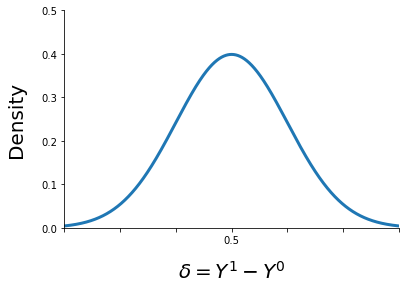

In [3]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(-5, 5, 5000)
pdf = ss.norm.pdf(x, 0, 1)
ax.plot(x, pdf)
    
ax.set_xlabel('$\delta = Y^1 - Y^0$')
ax.set_ylabel('Density')
ax.set_xticklabels(['', '', '', 0.5, '', '', ''])
ax.set_xlim([-3, 3])
ax.set_ylim([0, 0.5]);

* There might be considerable heterogeneity in the benefits of treatment among the population. And summarizing the distribution of benefits with a single number, for example $E[\delta]$, might result in a loss of information.

**Examples**

* medical treatment
* ..

Give our definitions of $(Y^1, Y^0, D)$ and their individual realizations $(y^1_i, y^0_i, d_i)$ we can now define the observed outcome $Y$ in terms of them.

\begin{align*}
Y = \begin{cases}
Y^1 & \quad\text{if}\quad D = 1 \\
Y^0 & \quad\text{if}\quad D = 0
\end{cases}
\end{align*}

or more compactly in switching-regime notation

\begin{align*}
Y = D Y^1 + (1 - D) Y^0.
\end{align*}

This leads Holland (1986) to describe the fundamental problem of causal inference:

<img src="material/fundamental_problem.png" height="500" width=500 />

$\rightarrow$ as only the diagonal of the table is observable we cannot simply compute $\delta_i$ by taking the difference in potential outcomes $(y^1_i, y^0_i)$.

In [4]:
df.head()

,treat,re78,Y,Y_0,Y_1,D
93,1,9983.7840,9983.7840,NaN,9983.7840,1
8,1,2164.0220,2164.0220,NaN,2164.0220,1
210,0,0.0000,0.0000,0.0,NaN,0
54,1,590.7818,590.7818,NaN,590.7818,1
101,1,9265.7880,9265.7880,NaN,9265.7880,1


## Population-level parameters

It looks like we need to give our our hope of obtaining the individual-specific effect of treatment. But what can we still hope for?

$\rightarrow$ population-level parameters

* What are common examples?

* What are the policy questions they address?

* What is their relationship to each other?

\begin{align*}
\begin{array}{lll}
E[Y^1 - Y^0] & \qquad ATE & \qquad\text{average effect of treatment} \\
E[Y^1 - Y^0 \mid D = 1] & \qquad ATT & \qquad\text{average effect on treated} \\
E[Y^1 - Y^0 \mid D = 0] & \qquad ATC & \qquad\text{average effect on untreated}
\end{array}
\end{align*}

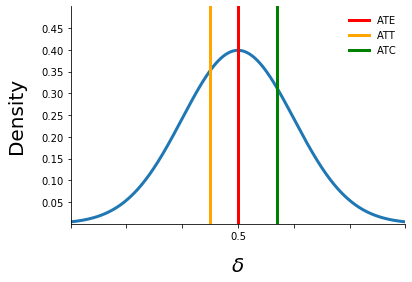

In [5]:
plot_individual_specific_effects(with_parameters=[0, 0.7, -0.5])

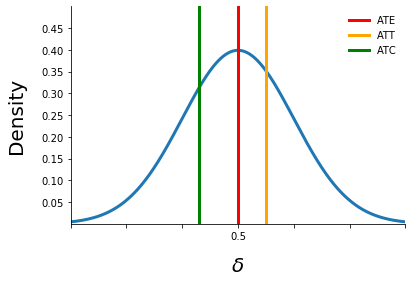

In [6]:
plot_individual_specific_effects(with_parameters=[0, -0.7, 0.5])

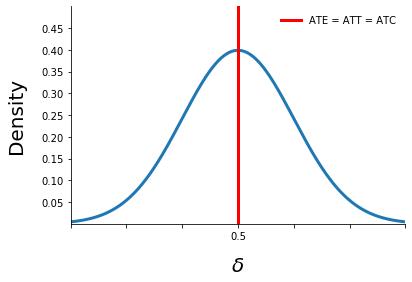

In [7]:
plot_individual_specific_effects(with_parameters=[0, 0, 0])

The potential outcome model is gets its empirical tractability when combined with the **Stable Unit Treatment Value Assumption (SUTVA)** of which there exist many formulations. We will go with the one from Imbens and Rubin (2015):

> The potential outcomes for any unit do not vary with the treatments assigned to other units, and, for each unit there are no different forms or versions of each treatment level, which lead to different potential outcomes.

* When do we need to expect this is vioated?


<img src="material/stable_unit_treatment.png" height="500" width=500 />

* randomized experiment

\begin{align*}
(Y^0, Y^1)  \perp \!\!\! \perp D
\end{align*}

* observational study

> A *observational study* is an empirical investigation of treatments, policies, or exposures and the effects they cause, but it differs from an experiment in that the investigator cannot control the assignment of treatments to subjects. (Rosenbaum (2002))

\begin{align*}
\hat{\delta}_{NAIVE} = E_N[y_i\mid d_i = 1] - E_N[y_i\mid d_i = 0]
\end{align*}

where 

\begin{align*}
E_N[y_i\mid d_i = 1] \xrightarrow{p} E[Y^1\mid D = 1] \neq E[Y^1]\\
E_N[y_i\mid d_i = 0] \xrightarrow{p} E[Y^0\mid D = 0] \neq E[Y^0]
\end{align*}

\begin{align*}
E[\delta] & = \{\pi E[Y^1\mid D = 1] + (1 - \pi)E[Y^1\mid D = 0]\} \\
          & - \{\pi E[Y^0\mid D = 1] + (1 - \pi)E[Y^0\mid D = 0]\}
\end{align*}


* Which components can be easily computed from data?

\begin{align*}
E[Y^1 \mid D = 1] - E[Y^0 \mid D = 0] & = E[\delta] + \{E[Y^0\mid D= 1] - E[Y^0\mid D= 0]\} \\
                                      & + (1 - \pi) \{E[\delta \mid D = 1] -E[\delta \mid D = 0]\}
\end{align*}

* baseline bias
* differential treatment effect bias

<img src="material/bias_example.png" height="500" width=500 />

What assumptions suffice to estimate the ATE with the naive estimator?

* about potential outcomes for subsets of the population 
* about the treatment selection / assignment process 

Consider the following two assumptions:

\begin{align*}
E[Y^1\mid D = 1] = E[Y^1\mid D = 0] \\
E[Y^0\mid D = 1] = E[Y^0\mid D = 0] \\
\end{align*}

and recall our naive estimate 


\begin{align*}
\hat{\delta}_{NAIVE} & = E_N[y_i\mid d_i = 1] - E_N[y_i\mid d_i = 0] \\
                     & \xrightarrow{p} E[Y^1\mid D = 1] - E[Y^0\mid D = 0] 
\end{align*}

* What happeens if the two assumptions or at least one is satisfied?


### Missing data and imputation

This is an adopted example from Imbens & Rubin (2015).

In [8]:
df = get_lalonde_data()
df.head()

,treat,re78,Y,Y_0,Y_1,D
325,0,10877.350,10877.350,10877.35,NaN,0
157,1,9371.037,9371.037,NaN,9371.037,1
254,0,0.000,0.000,0.00,NaN,0
296,0,0.000,0.000,0.00,NaN,0
6,1,0.000,0.000,NaN,0.000,1


We can impute the missing values simply by their average counterpart.

In [9]:
df.loc[df['D'] == 0, 'Y_1'] = df['Y_1'].mean()
df.loc[df['D'] == 1, 'Y_0'] = df['Y_0'].mean()
print('Our estimated treatment effect is {:10.2f}'.format((df['Y_1'] - df['Y_0']).mean()))

Our estimated treatment effect is    1794.34


However, this does not really account for any uncertainty in our estimate. Can we do better?

In [10]:
np.random.seed(123)       # set seed to ensure reproducibility
df = get_lalonde_data()   # get the original data

status_counts = df['D'].value_counts().to_dict()

stats = list()
for _ in range(100):
    y_1_sampled = df['Y_1'].dropna().sample(n=status_counts[0], replace=True).values
    y_0_sampled = df['Y_0'].dropna().sample(n=status_counts[1], replace=True).values

    df_boot = df.copy()

    df_boot.loc[df_boot['D'] == 1, 'Y_0'] = y_0_sampled
    df_boot.loc[df_boot['D'] == 0, 'Y_1'] = y_1_sampled
    
    stat = (df_boot['Y_1'] - df_boot['Y_0']).mean()
    stats.append(stat)
print('Our estimated treatment effect is {:10.2f}'.format(np.mean(stats)))

Our estimated treatment effect is    1803.06


How does the full distribution of estimates look like?

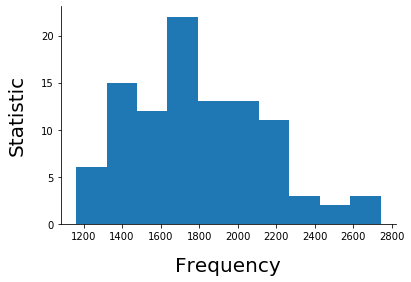

In [11]:
fig, ax = plt.subplots(1, 1)
ax.hist(stats)
ax.set_ylabel('Statistic')
ax.set_xlabel('Frequency');

Still some limitations remains. For example, we do sample from the empirical distribution of the observed outcomes and the actual distribution. Phrased differently, we treat the distribution of potential outcomes as knows and abstract from any uncertainty in our knowledge about it.

## Extensions of the binary potential outcome model

* over-time potential outcomes and causal effects
    * a single unit over time (time series data)
    * many units over time (panel data)
    
* many-valued treatments

### Over-time potential outcomes

We explore the case of a single unit over time.

**Ingredients** 

* discrete time periods, $t\in\{1, ..., T\}$
* sequence of observed values, $\{y_1, y_2, ..., y_T\}$



Setting up the potential outcome model to explore the basic features of before-and-after designs for a single unit of analsysis.

* before the treatment is introduced (for $t < t^*$):

\begin{align*}
D_t & = 0 \\
Y_t & = Y^0_t\\
\end{align*}

* while the treatment is in place (from $t^*$ through $t^* + k$):

\begin{align*}
D_t & = 1 \\
Y_t & = Y^1_t\\
Y^0_t & \text{exists but is counterfactual}
\end{align*}

* after the treatment ends (for time periods $t > (t^* + k)$):
\begin{align*}
D_t & = 0 \\
Y_t & = Y^0_t\\
Y^1_t & \text{exists but is counterfactual}
\end{align*}

The following is an adapted example from our textbook. 

* **year of the fire horse**, Japanese folk belief that families who give birth to babies will suffer untold miseries

We are interested in its effect on the birth rate in Japan

\begin{align*}
\delta_{1966} = y^1_{1966} - y^0_{1966}
\end{align*}

and attempt to estimate it by

\begin{align*}
\hat{\delta}_{1966} & = y_{1966} - y^0_{1966}\\
\end{align*}

In [85]:
# source: https://data.worldbank.org/indicator/sp.dyn.cbrt.in
df = wb.download(indicator = {'SP.DYN.CBRT.IN':'Birth rate'}, country=["JPN"], start=1960)


df.sort_index(inplace=True)       # sort by year
df.columns=['Birth rate']
df.index = df.index.droplevel(0)
df.index = df.index.astype(int)   # format index to integer type
df.head()

,Birth rate
year,
1960,17.3
1961,17.0
1962,17.1
1963,17.4
1964,17.8


Let's get to work.

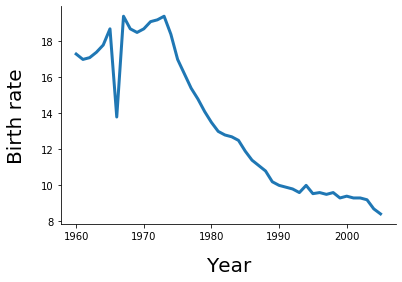

In [86]:
fig, ax = plt.subplots(1, 1)
ax.plot(df['Birth rate'].index, df['Birth rate'])
ax.set_ylabel('Birth rate')
ax.set_xlabel('Year');

In [87]:
df.loc[slice(1960, 1970), 'Birth rate']

year
1960    17.3
1961    17.0
1962    17.1
1963    17.4
1964    17.8
1965    18.7
1966    13.8
1967    19.4
1968    18.7
1969    18.5
1970    18.7
Name: Birth rate, dtype: float64

In [88]:
y_0 = df.loc[[1963, 1969], 'Birth rate'].mean()
y_1 = df.loc[1966, 'Birth rate']
print(' A reasonable treatment effect is {:10.5f}'.format(y_1 - y_0))

 A reasonable treatment effect is   -4.15000


## References

Holland, P. W. (1986). Statistics and causal inference. *Journal of the American Statistical Association*, 81(396), 945–960.  
Imbens, G. W. & Rubin, D. B. (2015). *Causal inference in statistics, social, and biomedical sciences*. Cambridge University Press.  
Rosenbaum, P. R. (2002). Overt bias in observational studies. In *Observational studies* (pp. 71–104). Springer.

In [ ]:
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen('http://bit.ly/2DeuEQx')
HTML(html.read().decode('utf-8'))